# Fine Tuning BERT for Sentiment Analysis with PyTorch

References:
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)
- [Estratégias eficazes para lidar com conjuntos de dados desbalanceados](https://medium.com/@daniele.santiago/estrat%C3%A9gias-eficazes-para-lidar-com-conjuntos-de-dados-desbalanceados-5b873894483b)
- [Aprenda a balancear seus dados com Undersampling e Oversampling em Python](https://medium.com/@daniele.santiago/aprenda-a-balancear-seus-dados-com-undersampling-e-oversampling-em-python-6fd87095d717#:~:text=J%C3%A1%20o%20over%2Dsampling%2C%20por,t%C3%A9cnicas%20foi%20explicitada%20neste%20artigo.)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample)
- [REPRODUCIBILITY](https://pytorch.org/docs/stable/notes/randomness.html)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = False  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

## Installing and Importing Required Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

## Config

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"
if running_colab:
    GLASSDOOR_MODEL_PATH = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/train_model/"
if running_kaggle:
    GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "/kaggle/working/"
if running_local:
    GLASSDOOR_MODEL_PATH = "./bertimbau-glassdoor-reviews-epoch_5.bin"
    PATH_TO_SAVE_MODEL = "./train_model/"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [6]:
torch.manual_seed(RANDOM_SEED)

In [7]:
random.seed(RANDOM_SEED)

In [8]:
np.random.seed(RANDOM_SEED)

## Importing and Preprocessing the Dataset

In [9]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [10]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",15 de dez. de 2023,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,15 de dez. de 2023,5.0,0,1


In [11]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [12]:
filtered_dataset.shape

(2566, 2)

In [13]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1284
-1    1035
 0     247
Name: count, dtype: int64

In [14]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [15]:
num_labels

3

In [16]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [17]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [18]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [19]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [20]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [21]:
train_data.shape

(2052, 2)

In [22]:
test_data.shape

(514, 2)

## Create a PyTorch Dataset

In [23]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = TOKEN_MAX_LENGTH

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [24]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [25]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [27]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

## Model training functions

In [28]:
def train(model, data_loader, loss_fun, optimizer, n_total_steps):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [29]:
def test(model, data_loader, loss_fun, n_total_steps):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [30]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "Train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "Test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title("Training and Test Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

In [31]:
def start_training(model, train_loader, loss_fun, optimizer, epochs, n_total_steps):
    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"{'-'*20} Epoch: {t + 1}/{epochs} {'-'*20}")

        train_loss = train(model, train_loader, loss_fun, optimizer, n_total_steps)
        train_losses.append(train_loss)

        print("")

        test_loss = test(model, test_loader, loss_fun, n_total_steps)
        test_losses.append(test_loss)

        print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
        print("\n\n")

    return train_losses, test_losses

## Model Evaluation functions

In [32]:
def evaluate_model(model, test_loader, device):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            _, predictions = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [33]:
def show_confusion_matrix(all_labels, all_preds, normalize=None):
    cm = confusion_matrix(all_labels, all_preds, normalize=normalize)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [56]:
def predict_reviews(model, reviews) -> None:
    class_names = ["neutral", "positive", "negative"]
    for review in reviews:
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=TOKEN_MAX_LENGTH,
            add_special_tokens=True,
            return_token_type_ids=False,
            # pad_to_max_length=True, # deprecated
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        input_ids = encoded_review["input_ids"].to(device)
        attention_mask = encoded_review["attention_mask"].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        probs = nn.functional.softmax(output, dim=1)

        print(f"Review text: {review}")
        # print(probs)
        print(pd.DataFrame(probs.tolist()[0], class_names)[0])
        print("\n")

    return None

## Training the Model (without oversampling)

### Training the Model 

In [35]:
model = GlassdoorReviewsClassifier(num_labels).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [36]:
loss_fun = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [38]:
n_total_steps = len(train_loader)
n_total_steps

129

In [39]:
train_losses, test_losses = start_training(
    model, train_loader, loss_fun, optimizer, EPOCHS, n_total_steps
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/129, 		 loss = 1.0036
Training Batch 32/129, 		 loss = 0.9533
Training Batch 48/129, 		 loss = 0.8683
Training Batch 64/129, 		 loss = 0.7528
Training Batch 80/129, 		 loss = 0.6705
Training Batch 96/129, 		 loss = 0.5110
Training Batch 112/129, 		 loss = 0.4404
Training Batch 128/129, 		 loss = 0.4814

Evaluating Batch 16/129, 		 loss = 0.9240
Evaluating Batch 32/129, 		 loss = 0.4542

Train Loss: 0.7616475843643957, 		 Test Loss: 0.4691062334812049



-------------------- Epoch: 2/5 --------------------
Training Batch 16/129, 		 loss = 0.2411
Training Batch 32/129, 		 loss = 0.3198
Training Batch 48/129, 		 loss = 0.2304
Training Batch 64/129, 		 loss = 0.2249
Training Batch 80/129, 		 loss = 0.1676
Training Batch 96/129, 		 loss = 0.3988
Training Batch 112/129, 		 loss = 0.4541
Training Batch 128/129, 		 loss = 0.2182

Evaluating Batch 16/129, 		 loss = 0.5509
Evaluating Batch 32/129, 		 loss = 0.2042

Train Loss

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

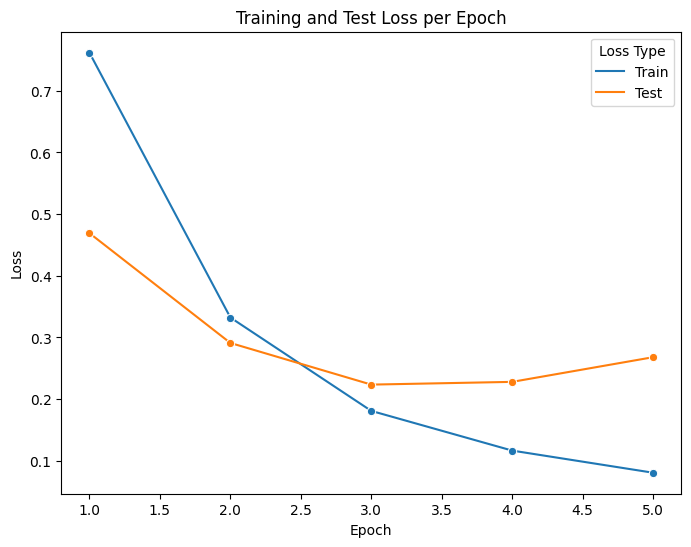

In [40]:
show_loss(train_losses, test_losses)

### Evaluating the Model

In [41]:
all_labels, all_preds = evaluate_model(model, test_loader, device)

In [43]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.69      0.77        45
           1       0.98      0.93      0.96       264
           2       0.89      0.99      0.94       205

    accuracy                           0.93       514
   macro avg       0.91      0.87      0.89       514
weighted avg       0.94      0.93      0.93       514



In [44]:
print(accuracy_score(all_labels, all_preds))

0.933852140077821


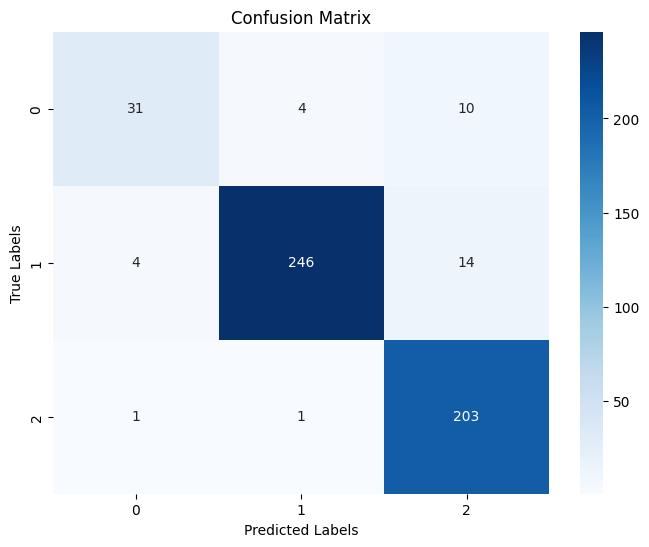

In [46]:
show_confusion_matrix(all_labels, all_preds)

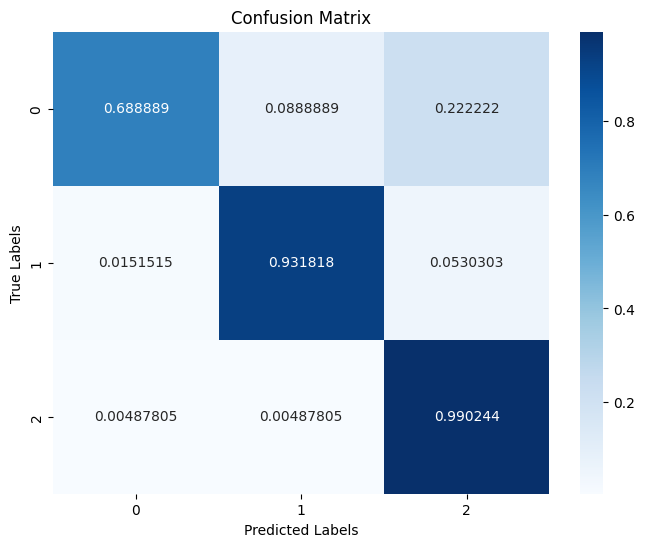

In [47]:
show_confusion_matrix(all_labels, all_preds, normalize="true")

### Saving the model

In [49]:
torch.save(model.state_dict(), f"bertimbau-glassdoor-reviews-epoch_{EPOCHS}.bin")

### Loading the model

In [50]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [51]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

### Sample prediction

In [52]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [57]:
predict_reviews(model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.006246
positive    0.989563
negative    0.004190
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.008667
positive    0.002909
negative    0.988424
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.943170
positive    0.029024
negative    0.027805
Name: 0, dtype: float64




## Training the model (with oversampling)

### Oversampling

In [58]:
def oversampling(train_df, minority_class=0, majority_classes=[1, 2]):
    # Desired number of samples for the minority class
    oversample_size = (
        train_df[train_df["sentiment"] == 0]["sentiment"].value_counts()[0] * 3
    )

    oversampler = RandomOverSampler(sampling_strategy={minority_class: oversample_size})
    X_res, y_res = oversampler.fit_resample(
        train_df[["review_text"]], train_df["sentiment"]
    )

    y_res_df = pd.DataFrame({"sentiment": y_res})
    resampled_df = pd.concat([X_res, y_res_df], axis=1)
    resampled_df.reset_index(drop=True, inplace=True)

    resampled_minority_df = resampled_df[resampled_df["sentiment"] == minority_class]

    # Concatenate the oversampled minority class with the majority class
    oversampled_df = pd.concat([train_df, resampled_minority_df])

    # Shuffle the DataFrame to randomize the order of samples
    oversampled_df = oversampled_df.sample(
        frac=1, random_state=RANDOM_SEED
    ).reset_index(drop=True)
    return oversampled_df

In [59]:
filtered_dataset.shape

(2566, 2)

In [60]:
filtered_dataset["sentiment"].value_counts()

sentiment
1    1284
2    1035
0     247
Name: count, dtype: int64

In [61]:
oversampled_filtered_dataset = oversampling(filtered_dataset)

In [62]:
oversampled_filtered_dataset.shape

(3307, 2)

In [63]:
oversampled_filtered_dataset["sentiment"].value_counts()

sentiment
1    1284
2    1035
0     988
Name: count, dtype: int64

### Training the Model

In [64]:
oversampled_train_data, oversampled_test_data = train_test_split(
    oversampled_filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [65]:
oversampled_train_dataset = GlassdoorReviewsDataset(oversampled_train_data, tokenizer)
oversampled_test_dataset = GlassdoorReviewsDataset(oversampled_test_data, tokenizer)

In [66]:
oversampled_train_loader = DataLoader(
    oversampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
oversampled_test_loader = DataLoader(
    oversampled_test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [67]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)

In [68]:
loss_fun = nn.CrossEntropyLoss()

In [69]:
oversampled_optimizer = torch.optim.Adam(
    oversampled_model.parameters(), lr=LEARNING_RATE
)

In [70]:
n_total_steps = len(oversampled_train_loader)
n_total_steps

166

In [72]:
oversampled_train_losses, oversampled_test_losses = start_training(
    oversampled_model,
    oversampled_train_loader,
    loss_fun,
    oversampled_optimizer,
    EPOCHS,
    n_total_steps,
)

-------------------- Epoch: 1/5 --------------------
Training Batch 16/166, 		 loss = 1.1025
Training Batch 32/166, 		 loss = 1.0515
Training Batch 48/166, 		 loss = 0.9270
Training Batch 64/166, 		 loss = 0.8441
Training Batch 80/166, 		 loss = 0.7403
Training Batch 96/166, 		 loss = 0.7014
Training Batch 112/166, 		 loss = 0.5421
Training Batch 128/166, 		 loss = 0.5369
Training Batch 144/166, 		 loss = 0.6484
Training Batch 160/166, 		 loss = 0.3599

Evaluating Batch 16/166, 		 loss = 0.4899
Evaluating Batch 32/166, 		 loss = 0.3126

Train Loss: 0.7834530914404306, 		 Test Loss: 0.3807553260615378



-------------------- Epoch: 2/5 --------------------
Training Batch 16/166, 		 loss = 0.4211
Training Batch 32/166, 		 loss = 0.2353
Training Batch 48/166, 		 loss = 0.2822
Training Batch 64/166, 		 loss = 0.6060
Training Batch 80/166, 		 loss = 0.1503
Training Batch 96/166, 		 loss = 0.4084
Training Batch 112/166, 		 loss = 0.3430
Training Batch 128/166, 		 loss = 0.2245
Training Batch

### Evaluating the Model

In [73]:
len(oversampled_train_losses)

5

In [74]:
len(oversampled_test_losses)

5

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

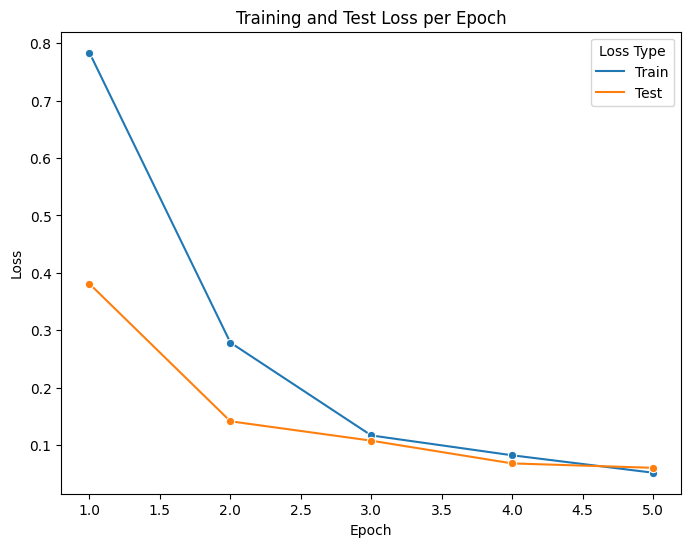

In [75]:
show_loss(oversampled_train_losses, oversampled_test_losses)

In [77]:
oversampled_all_labels, oversampled_all_preds = evaluate_model(
    oversampled_model, oversampled_test_loader, device
)

In [78]:
print(classification_report(oversampled_all_labels, oversampled_all_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       221
           1       0.94      0.96      0.95       235
           2       0.95      0.93      0.94       206

    accuracy                           0.95       662
   macro avg       0.96      0.95      0.95       662
weighted avg       0.95      0.95      0.95       662



In [79]:
print(accuracy_score(oversampled_all_labels, oversampled_all_preds))

0.9546827794561934


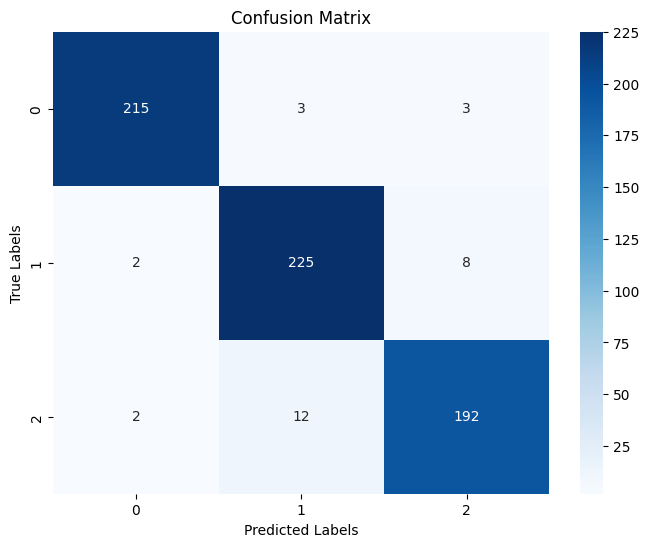

In [80]:
show_confusion_matrix(oversampled_all_labels, oversampled_all_preds)

### Saving the model

In [81]:
torch.save(
    oversampled_model.state_dict(),
    f"{PATH_TO_SAVE_MODEL}bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
)

### Loading the model

In [82]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [83]:
oversampled_model = GlassdoorReviewsClassifier(num_labels).to(device)
oversampled_model.load_state_dict(
    torch.load(
        GLASSDOOR_MODEL_PATH.replace(
            f"bertimbau-glassdoor-reviews-epoch_5.bin",
            f"bertimbau-glassdoor-reviews-oversampled-epoch_{EPOCHS}.bin",
        ),
        map_location=device,
    )
)
oversampled_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Sample prediction

In [84]:
reviews = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [85]:
predict_reviews(oversampled_model, reviews)

Review text: Empresa boa para trabalhar
neutral     0.002628
positive    0.994617
negative    0.002756
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
neutral     0.012243
positive    0.007026
negative    0.980731
Name: 0, dtype: float64


Review text: Não tenho o que declarar
neutral     0.994294
positive    0.003664
negative    0.002043
Name: 0, dtype: float64


